# Email Author Classification: Ensemble Learning Approach

## Overview & Descreption 

This project is to know the author of an email depending on his/her sytle of writing the email. 
The style of writing for the author is are detected by some of the words the he/she uses most of the time. 

### Our Dataset 

Our dataset consists of more than 15000 emails from two persons: Chris & Sara distriputed and labeled evenly between them. 
Note: The data is saved in a pickle file 'word_data.pkl' for email data, and 'email_authors.pkl' for the corresponding author. 

### Our Goal

Our goal is to classify from the testing data if the author of an email is Chris or Sara based using Ensemble Learning Methods. 

### Ensemble Learning 

We used the two main methods to compare between them in two main criteria: time of training & accuracy of testing. 

## Main Importings

In [1]:
import joblib
import pickle
import numpy as np
from time import time 

## Data Preprocessing 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif

In [3]:
def vectorize_transform(features_train, labels_train, features_test):
    """
        this function takes the features train and test data, vectorize the email data on them, 
        and select the most important words on them. 
        
        2 objects are teturned: 
            -- features_train_transformed 
            -- features_test_transformed 
    """
    ### text vectorization--go from strings to lists of numbers
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    features_train_transformed = vectorizer.fit_transform(features_train)
    features_test_transformed  = vectorizer.transform(features_test)


    ### feature selection, because text is super high dimensional and 
    ### can be really computationally chewy as a result
    selector = SelectPercentile(f_classif, percentile=10)
    selector.fit(features_train_transformed, labels_train)
    features_train_transformed = selector.transform(features_train_transformed).toarray()
    features_test_transformed  = selector.transform(features_test_transformed).toarray()
    
    return features_train_transformed, features_test_transformed
    

In [4]:
def preprocess(words_file = "./emails_data.pkl", authors_file="./emails_authors.pkl"):
    """ 
        this function takes a pre-made list of email texts (by default word_data.pkl)
        and the corresponding authors (by default email_authors.pkl) and performs
        a number of preprocessing steps:
            -- splits into training/testing sets (10% testing)
            -- vectorizes into tfidf matrix
            -- selects/keeps most helpful features

        after this, the feaures and labels are put into numpy arrays, which play nice with sklearn functions

        4 objects are returned:
            -- training/testing features
            -- training/testing labels
    """
    ### the words (features) and authors (labels), already largely preprocessed
    ### this preprocessing will be repeated in the text learning mini-project
    with open(authors_file, "rb") as  authors_file_handler: 
        authors = joblib.load(authors_file_handler)
    with open(words_file, "rb") as words_file_handler:
        word_data = joblib.load(words_file_handler)
        
    features_train, features_test, labels_train, labels_test = train_test_split(word_data, authors, test_size=0.1, random_state=42)
    features_train_transformed, features_test_transformed = vectorize_transform(features_train, labels_train, features_test)
    
    ### info on the data
    print("Data Summary: ")
    print("No. of Chris's emails in the datast : ", sum(authors))
    print("No. of Sara's emails in the dataset : ", len(authors)-sum(authors))
    print("="*70)
    print("No. of Chris training emails : ", sum(labels_train))
    print("No. of Sara training emails : ", len(labels_train)-sum(labels_train))
    
    return features_train_transformed, features_test_transformed, labels_train, labels_test

## Model Training  

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC

### Voting Classifier 

In [6]:
def train_voting(X_train, y_train, voting_type='hard'):
    """
        this function to train the model on a voting classifier that votes between 4 classifiers: 
        Random Forest, Support Vector Machine, Gaussian Naive Bayes, Logistic Regression. 
        
        it pickles the voting classifier in .clf file and returns the classifier. 
    """ 
    rnd_clf = RandomForestClassifier()
    svm_clf = SVC()
    nb_clf = GaussianNB()
    lr_clf = LogisticRegression() 
    
    voting_clf = VotingClassifier(
    estimators=[('rnd', rnd_clf), ('svm', svm_clf), ('nb', nb_clf), ('lr', lr_clf)], 
    voting=voting_type
    )
    
    t0 = time()
    voting_clf.fit(X_train, y_train)
    print(f"Time of training for the Voting Classifier : {time()-t0:.3}s")
    
    # Save the classifier 
    with open('voting_clf.clf', 'wb') as f:
        pickle.dump(voting_clf, f)
    
    return voting_clf 


### Bagging/Pasting Classifier

In [7]:
def train_bagging(X_train, y_train, bagging=True): 
    """
        this function to train the model on a bagging classifier that uses 500 small Decision Tress 
        of maxmium samples = 100 for each Decision Tree. 
        
        it pickles the bagging classifier in .clf file and returns the classifier. 
    """ 
    bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        max_samples=100, bootstrap=bagging, n_jobs=-1
    )

    t0 = time()
    bag_clf.fit(X_train, y_train)
    print(f"Training Time: {time()-t0:.3}s")
    
    # Save the classifier
    with open('bagging_clf.clf', 'wb') as f:
        pickle.dump(bag_clf, f)

    return bag_clf 

## Model Testing

In [8]:
from sklearn.metrics import classification_report

### Classification Report

In [9]:
def test_model(clf, X_test, y_test):
    """
        this function to test the ensemble classifiers we created using the score report.
        
        returns the predicted values 
    """
    t0 = time()
    y_pred = clf.predict(X_test) 
    print(f"Time of predicting for {clf.__class__.__name__} Classifier : {time()-t0:.3}s\n")
    print("\t\t=====Classification Report=====\n")
    print(classification_report(y_test, y_pred))
    
    return y_pred 
    

### Confusion Matrix Plotting 

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [11]:
def plot_confusion(y_test, y_pred):
    print("Test Confusion Matrix")

    ax = sns.heatmap(
        confusion_matrix(y_test, y_pred), annot=True, fmt='d', 
        xticklabels=['Sara', 'Chris'], yticklabels=['Sara', 'Chris']
    )

## Main Code 

### Load The Classifiers (if exist) 

In [ ]:
# If the you have the classifiers already 
try: 
    with open(r"voting_clf.clf", "rb") as f:
        voting_clf = pickle.load(f)
        print(voting_clf.__repr__)
    
    with open(r"bagging_clf.clf", "rb") as f: 
        bag_clf = pickle.load(f)
        print(bag_clf.__repr__)
except FileNotFoundError as e: 
    print(e)

### Train The Classifiers (if not exist)

In [12]:
X_train, X_test, y_train, y_test = preprocess() 

Data Summary: 
No. of Chris's emails in the datast :  8801
No. of Sara's emails in the dataset :  8777
No. of Chris training emails :  7936
No. of Sara training emails :  7884


In [13]:
voting_clf = train_voting(X_train, y_train)

Time of training for the Voting Classifier : 3.98e+02s


In [14]:
bag_clf = train_bagging(X_train, y_train, bagging=True)

Training Time: 3.83e+02s


### Voting Classifier Report & Confusion Matrix

In [15]:
y_pred_voting = test_model(voting_clf, X_test, y_test)

Time of predicting for VotingClassifier Classifier : 39.3s

		=====Classification Report=====

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       893
           1       0.99      0.99      0.99       865

    accuracy                           0.99      1758
   macro avg       0.99      0.99      0.99      1758
weighted avg       0.99      0.99      0.99      1758



Voting Classifier
Test Confusion Matrix


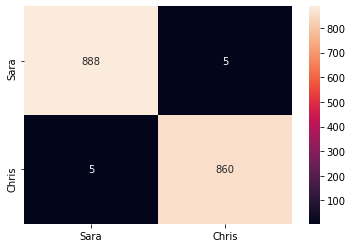

In [16]:
print("Voting Classifier")
plot_confusion(y_test, y_pred_voting)

### Bagging Classifier Report & Confusion Matrix 

In [17]:
y_pred_bag = test_model(bag_clf, X_test, y_test)

Time of predicting for BaggingClassifier Classifier : 16.5s

		=====Classification Report=====

              precision    recall  f1-score   support

           0       0.95      0.75      0.84       893
           1       0.79      0.96      0.87       865

    accuracy                           0.85      1758
   macro avg       0.87      0.86      0.85      1758
weighted avg       0.87      0.85      0.85      1758



Bagging Classifier
Test Confusion Matrix


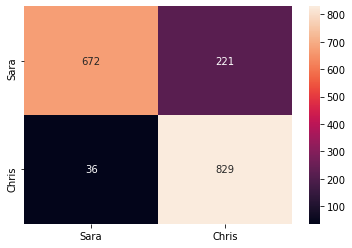

In [18]:
print("Bagging Classifier")
plot_confusion(y_test, y_pred_bag)

## Conclusion 

From previous metrics comparison between two common Ensemble Learning approachs, in our use case we found that: 
- The Hard Voting classifier is more accurate (99%) than the Bagging classifier (85%). 
- The Hard Voting classifier is slower in training & prediction time than the Bagging classifier. 